In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# torch.manual_seed
import pandas as pd

import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

### FNO

The Temperature evolution of the solid and fluid phases $T_S$a nd $T_f$ is described by a sdystem of two linear reaction-convection diffusion equation $$\begin{aligned} \varepsilon \rho_{f} C_{f} \frac{\partial T_{f}}{\partial t}+\varepsilon \rho_{f} C_{f} u_{f}(t) \frac{\partial T_{f}}{\partial x}=\lambda_{f} \frac{\partial^{2} T_{f}}{\partial x^{2}}-h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T] \\ (1-\varepsilon) \rho_{s} C_{s} \frac{\partial T_{s}}{\partial t}=\lambda_{s} \frac{\partial^{2} T_{s}}{\partial x^{2}}+h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T]\end{aligned}$$


### Learning Operators

Mapping between two infinite dimensional spaces from a finite collection of observed input-output pairs (i.e $(t, T_s)$ and $(t, T_f)$)

We want to find a solution operator (map) $G^\dagger$ of the parametric PDE above by constructing a parametric map $$ G_\theta: \mathcal{A} \rightarrow \mathcal{U}$$ for some parameter $\theta^\dagger \in \Theta$ (where $\Theta$ is some finite dimensional parameter space), such that this approximation map $$G(\cdot, \theta^\dagger) = G_{\theta^\dagger} \simeq G^\dagger$$

Approximating this solution operator $G^\dagger$ is different than finding the solution $u \in \mathcal{U}$ of a PDE for a single instance of the parameter $a \in \mathcal{A}$

## Operator Learning

- The spatial domain for the PDE $D \subset \mathbb{R}^d$ (in our case simply $t \in \mathbb{R}$, where $t$ correspond to the points in the spatial domain)
- $a \in \mathcal{A} = (D; \mathbb{R}^{d_a})$ are the **input coefficient functions**
- $u \in \mathcal{U} = (D; \mathbb{R}^{d_u})$ are the **target solution functions**

Given a set of observations s $\{a_j, u_j\}_{j =1}^N$, the function $D_j$ describes the discretization of $(a_j, u_j)$

In [3]:
train_data = pd.read_csv("Task3/TrainingData.txt")
test_data = pd.read_csv("Task3/TestingData.txt")
display(train_data)

t_train_import = torch.from_numpy(train_data['t'].to_numpy()).type(torch.float32)
t_pred = torch.from_numpy(test_data['t'].to_numpy()).type(torch.float32)

Tf0 = torch.from_numpy(train_data['tf0'].to_numpy()).type(torch.float32)
Ts0 = torch.from_numpy(train_data['ts0'].to_numpy()).type(torch.float32)

,t,tf0,ts0
0,0.00,873.000000,293.000000
1,2478.06,873.000000,655.920736
2,4956.12,873.000000,792.106226
3,7434.18,873.000000,842.176577
4,9912.24,873.000000,861.040655
...,...,...,...
205,508002.30,730.794575,730.514961
206,510480.36,730.053663,729.797475
207,512958.42,729.371039,729.133162
208,515436.48,728.734400,728.511278


### Normalize Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
# load data
# create scaler
scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()
# # inverse transform
# inverse = scaler.inverse_transform(normalized)

t_train_norm = scaler_t.fit_transform(train_data['t'].to_numpy().reshape(-1, 1))
t_test_norm = scaler_t.fit_transform(test_data['t'].to_numpy().reshape(-1, 1))
Tf0_norm = scaler_Tf.fit_transform(train_data['tf0'].to_numpy().reshape(-1, 1))
Ts0_norm = scaler_Ts.fit_transform(train_data['ts0'].to_numpy().reshape(-1, 1))

Text(0.5, 1.0, 'Normalized data')

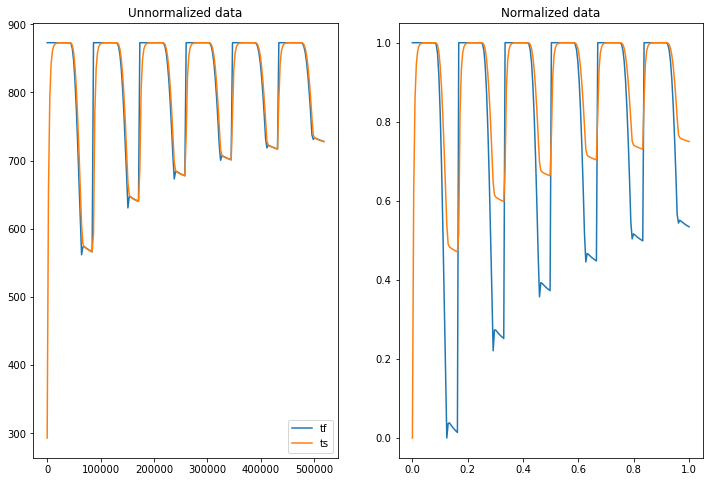

In [115]:
fig, ax = plt.subplots(1,2, figsize = (12, 8))

ax[0].plot(t_train_import, Tf0, label = "tf")
ax[0].plot(t_train_import, Ts0, label = 'ts')
ax[0].legend()
ax[0].set_title("Unnormalized data")

ax[1].plot(t_train_norm, Tf0_norm, label = 'tf_norm')
ax[1].plot(t_train_norm, Ts0_norm, label = 'ts_norm')
ax[1].set_title("Normalized data")

#### Obtain $\Delta t$

In [20]:
delta_t = t_pred[1] - t_pred[0]
delta_t_norm = t_train_norm[1] - t_train_norm[0]
print(delta_t_norm)

[0.00478469]


#### Get the a(t)

In [51]:
a_t = []
for idx, t in enumerate(t_train_import):
    # print(idx)
    if idx == (len(t_train_import)-1):
        print("last element")
    else:
        a_idx = (Tf0[idx+1] - Tf0[idx])/(delta_t*(Tf0[idx] - Ts0[idx]))
        # print(a_idx)
        a_t.append(a_idx)

a_t = torch.tensor(a_t)
# a_t = a_t.numpy()

last element


tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -7.3596e-05, -2.7060e-04,
        -6.0869e-04, -1.0089e-03, -1.0901e-03, -1.1138e-03, -1.1234e-03,
        -1.1084e-03, -1.1192e-03, -9.3048e-02,  3.5746e-03,  1.4307e-03,
         9.8085e-04,  7.8270e-04,  6.6903e-04,  5.9409e-04,  5.4034e-04,
         4.9955e-04, -1.0547e-04, -4.5424e-05, -2.1249e-03, -1.0942e-03,
        -1.0651e-03, -1.0701e-03, -1.0758e-03, -1.0801e-03,  3.4913e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0339e-04, -2.9171e-04,
        -6.8553e-04, -1.0352e-03, -1.0886e-03, -1.1220e-03, -1.1049e-03,
        -1.1049e-03, -1.1145e-03, -1.3911e-01,  3.0455e-03,  1.4085e-03,
         9.9744e-04,  8.0841e-04,  6.9829e-04,  6.2545e-04,  5.7336e-04,
         5.3411e-04, -1.7552e-04,  3.2822e-05, -1.6156e-03, -1.0837e-03,
        -1.0660e-03, -1.0715e-03, -1.0769e-03, -1.0

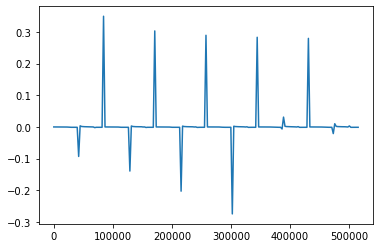

In [52]:
# print(a_t)
plt.plot(t_train_import[:-1], a_t)

In [53]:
a_t_norm = []
for idx, t in enumerate(t_train_norm):
    if idx == (len(t_train_norm) - 1):
        print("Last element")
    else:
        a_idx = (Tf0_norm[idx+1] - Tf0_norm[idx])/(delta_t*(Tf0_norm[idx] - Ts0_norm[idx]))
        a_t_norm.append(a_idx)
a_t_norm = torch.tensor(a_t_norm)
# a_t_norm = a_t_norm.numpy()

Last element


In [102]:
n_train = 178
batch_size = 178

t_train = t_train_norm[:n_train].reshape(-1,1)
t_test =  t_train_norm[n_train:-1].reshape(-1,1)

t_train = torch.from_numpy(t_train).type(torch.float32)
t_test = torch.from_numpy(t_test).type(torch.float32)

Tf0_norm_torch = torch.from_numpy(Tf0_norm).type(torch.float32)
Ts0_norm_torch = torch.from_numpy(Ts0_norm).type(torch.float32)

# Output Set
Tf0_train = Tf0_norm_torch[:n_train]
Ts0_train = Ts0_norm_torch[:n_train]

Tf0_test = Tf0_norm_torch[n_train:-1]
Ts0_test = Ts0_norm_torch[n_train:-1]

at_train = a_t_norm[:n_train].reshape(-1,1)
at_test = a_t_norm[n_train:].reshape(-1,1)

input_train_tf0 = torch.cat((t_train, at_train), 1).type(torch.float32)
input_test_tf0 = torch.cat((t_test, at_test), 1).type(torch.float32)

torch.unsqueeze(input_train_tf0, dim=0)
torch.unsqueeze(input_test_tf0, dim=0)

print(input_train_tf0.shape)
print(input_test_tf0.shape)
print(Tf0_train.shape)
print(Tf0_test.shape)

training_set_tf0 = DataLoader(TensorDataset(input_train_tf0, Tf0_train), batch_size=batch_size, shuffle=True)
testing_set_tf0 =  DataLoader(TensorDataset(input_test_tf0, Tf0_test), batch_size=batch_size, shuffle=True)


torch.Size([178, 2])
torch.Size([31, 2])
torch.Size([178, 1])
torch.Size([31, 1])


### Plot Training and Testing Points

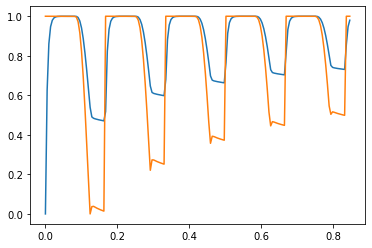

In [103]:
plt.plot(t_train, Ts0_train, label="Ts0")
plt.plot(t_train, Tf0_train, label="Tf0")

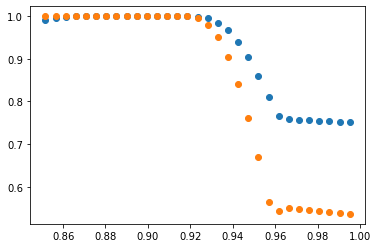

In [104]:
plt.scatter(t_test, Ts0_test, label="Ts0")
plt.scatter(t_test, Tf0_test, label="Tf0")

### FNO1D Implementation

In [105]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

In [107]:
learning_rate = 0.001

# epochs = 250
epochs = 250
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno = FNO1d(modes, width)

#### Optimizer

In [108]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_tf0):
        print(input_batch.shape)
        print(output_batch.shape)
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        # print(output_pred_batch)
        # print(output_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_tf0)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_tf0):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_tf0)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 0  ######### Train Loss: 0.5939539074897766  ######### Relative L2 Test Norm: 77.57982635498047
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 1  ######### Train Loss: 0.4518243372440338  ######### Relative L2 Test Norm: 64.47579193115234
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 2  ######### Train Loss: 0.3281303942203522  ######### Relative L2 Test Norm: 50.32514190673828
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 3  ######### Train Loss: 0.21996447443962097  ######### Relative L2 Test Norm: 35.588523864746094
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 4  ######### Train Loss: 0.13688650727272034  ######### Relative L2 Test Norm: 24.510618209838867
torch.Size([178, 2])
torch.Size([178, 1])


/Users/fabianjaeger/miniconda/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([178, 1])) that is different to the input size (torch.Size([1, 178])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


######### Epoch: 5  ######### Train Loss: 0.096783347427845  ######### Relative L2 Test Norm: 25.868057250976562
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 6  ######### Train Loss: 0.10972552001476288  ######### Relative L2 Test Norm: 33.11991882324219
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 7  ######### Train Loss: 0.14737196266651154  ######### Relative L2 Test Norm: 35.89610290527344
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 8  ######### Train Loss: 0.16459082067012787  ######### Relative L2 Test Norm: 33.88306427001953
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 9  ######### Train Loss: 0.1541016399860382  ######### Relative L2 Test Norm: 29.29616928100586
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 10  ######### Train Loss: 0.12994375824928284  ######### Relative L2 Test Norm: 24.849409103393555
torch.Size([178, 2])
torch.Size([178, 1])
######### Epoch: 11  ######### Train Loss: 0.10735321789979935  

KeyboardInterrupt: 

In [75]:
# idx_data = 4
input_function_train_n = input_data_train
output_function_train_tf = Tf0_train

plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=8, c="C0")


NameError: name 'input_data_train' is not defined

# Archive

#### Get prediction with 2D Data

In [ ]:
# idx_data = 4
input_function_train_n = input_train
output_function_train_tf = Tf0_train


output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=2, c="red")
plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
p = 2
err = (torch.mean(abs(output_function_train_tf.detach().reshape(-1, ) - output_function_train_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_train_tf.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()


In [ ]:
input_function_test_n = input_test
# print(len(input_function_test_n))
output_function_test_tf = Tf0_test


output_function_test_pred_n = fno(input_function_test_n)
# print(output_function_test_pred_n.shape)
output_function_test_pred_n = output_function_test_pred_n.detach()[0,:,0]
print(output_function_test_pred_n.shape)
print(input_function_test_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_test_n[:,0], output_function_test_pred_n, label="Approximate Solution", s=8, c="C0")
plt.plot(input_function_test_n, output_function_test_tf, label="True Solution", c="C0", lw=2)


# Optimizer with (t, T_f)


In [ ]:
n_train = 178 # 85 percent
# Input set
t_train = t_train_norm[:n_train].reshape(-1,1)
t_test =  t_train_norm[n_train:].reshape(-1,1)

t_train = torch.from_numpy(t_train).type(torch.float32)
t_test = torch.from_numpy(t_test).type(torch.float32)


Tf0_norm_torch = torch.from_numpy(Tf0_norm).type(torch.float32)
Ts0_norm_torch = torch.from_numpy(Ts0_norm).type(torch.float32)

# Output Set
Tf0_train = Tf0_norm_torch[:n_train]
Ts0_train = Ts0_norm_torch[:n_train]

Tf0_test = Tf0_norm_torch[n_train:]
Ts0_test = Ts0_norm_torch[n_train:]


input_train_tf0 = torch.cat((t_train, Tf0_train), 1)
input_test_tf0 = torch.cat((t_test, Tf0_test), 1)


print(input_train_tf0.shape)

training_set_tf0 = DataLoader(TensorDataset(input_train_tf0, Tf0_train), batch_size=batch_size, shuffle=True)
testing_set_tf0 =  DataLoader(TensorDataset(input_test_tf0, Ts0_test), batch_size=batch_size, shuffle=True)

batch_size = 178

# training_set_tf0 = DataLoader(TensorDataset(t_train, Tf0_train), batch_size=batch_size, shuffle=True)
# training_set_ts0 = DataLoader(TensorDataset(t_train, Ts0_train), batch_size=batch_size, shuffle=True)

# testing_set_tf0 = DataLoader(TensorDataset(t_test, Tf0_test), batch_size=batch_size, shuffle=True)
# testing_set_ts0 = DataLoader(TensorDataset(t_test, Ts0_test), batch_size=batch_size, shuffle=True)
# batch_size = 178

# training_set_tf0_2d = DataLoader(TensorDataset(input_train, Tf0_train), batch_size=batch_size, shuffle=True)
# training_set_ts0_2d = DataLoader(TensorDataset(input_train, Ts0_train), batch_size=batch_size, shuffle=True)

# testing_set_tf0_2d = DataLoader(TensorDataset(input_test, Tf0_test), batch_size=batch_size, shuffle=True)
# testing_set_ts0_2d = DataLoader(TensorDataset(input_test, Ts0_test), batch_size=batch_size, shuffle=True)

In [355]:
epochs = 100
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_tf0):
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno(input_batch)
        print("Output batch pred: {}".format(output_pred_batch))
        print("Output batch: {}".format(output_batch))
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_tf0)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_tf0):
            output_pred_batch = fno(input_batch)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_tf0)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


Output batch pred: tensor([[[0.3863],
         [0.7175],
         [0.9902],
         [0.9276],
         [0.9932],
         [0.5004],
         [0.0226],
         [0.9939],
         [0.9962],
         [0.9946],
         [0.9851],
         [0.9977],
         [0.9970],
         [0.9968],
         [0.2532],
         [0.9980],
         [0.9825],
         [0.9959],
         [0.9945],
         [0.9932],
         [0.9899],
         [0.9905],
         [0.9932],
         [0.9941],
         [0.9961],
         [0.5064],
         [0.9986],
         [0.9983],
         [1.0013],
         [1.0013],
         [0.9996],
         [0.9990],
         [0.4468],
         [0.4495],
         [0.9949],
         [0.9962],
         [0.9598],
         [0.8452],
         [0.9980],
         [0.0400],
         [0.9856],
         [0.0603],
         [0.6574],
         [0.9953],
         [0.9939],
         [0.4651],
         [0.9937],
         [0.9179],
         [0.3422],
         [0.4632],
         [0.9974],
         [0.

/Users/fabianjaeger/miniconda/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([178, 1])) that is different to the input size (torch.Size([1, 178, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Output batch pred: tensor([[[1.0265],
         [0.6272],
         [0.3549],
         [0.3140],
         [1.0247],
         [0.8705],
         [1.0311],
         [1.0301],
         [0.5422],
         [0.4806],
         [0.9545],
         [1.0228],
         [1.0192],
         [1.0157],
         [1.0149],
         [0.3490],
         [0.7352],
         [0.5920],
         [1.0273],
         [0.6023],
         [0.4778],
         [0.7411],
         [0.6073],
         [1.0328],
         [0.4686],
         [1.0208],
         [1.0152],
         [1.0125],
         [0.4147],
         [1.0121],
         [1.0164],
         [1.0216],
         [1.0277],
         [1.0322],
         [0.5490],
         [0.5494],
         [1.0362],
         [1.0348],
         [0.5408],
         [1.0310],
         [0.9982],
         [0.1599],
         [0.5929],
         [1.0284],
         [1.0279],
         [0.9980],
         [0.1439],
         [0.6097],
         [1.0260],
         [1.0223],
         [1.0187],
         [1.

In [ ]:
# idx_data = 4
input_function_train_n = input_train
output_function_train_tf = Tf0_train


output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=2, c="red")
plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
p = 2
err = (torch.mean(abs(output_function_train_tf.detach().reshape(-1, ) - output_function_train_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_train_tf.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()


# Optimizer with 1D Data

In [ ]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_tf0):
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        print(output_pred_batch)
        print(output_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_tf0)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_tf0):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_tf0)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


In [ ]:
# idx_data = 4
input_function_train_n = input_data_train
output_function_train_tf = Tf0_train

plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=8, c="C0")


In [ ]:
input_function_test_n = input_data_test
output_function_test_tf = Tf0_test

plt.plot(input_function_test_n, output_function_test_tf, label="True Solution", c="C0", lw=2)
output_function_test_pred_n = fno(input_function_test_n)
# print(output_function_test_pred_n.shape)
output_function_test_pred_n = output_function_test_pred_n.detach()[0,:,0]
print(output_function_test_pred_n.shape)
print(input_function_test_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_test_n[:,0], output_function_test_pred_n, label="Approximate Solution", s=8, c="C0")


### FNO 2D Implementation

In [ ]:
################################################################
#  2d fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x